# Notas de versión

- Se cambiaron los rangos de los parámetros

### Se necesitarom cálculos de integrales para las funciones base

#### Integral numérica para el cálculo de las funciones base específicas del experimento:

Uniform grid

For a domain discretized into ${\displaystyle N}$ equally spaced panels, considerable simplification may occur. Let

$ {\displaystyle \Delta x={\frac {b-a}{N}}}$
the approximation to the integral becomes

${\displaystyle \int _{a}^{b}f(x)\,dx\approx } 
{\displaystyle {}={\frac {\Delta x}{2}}(f(x_{0})+2f(x_{1})+2f(x_{2})+2f(x_{3})+\dotsb +2f(x_{N-1})+f(x_{N}))}
{\displaystyle {}={\frac {\Delta x}{2}}\left(f(x_{0})+f(x_{N})+2\sum _{k=1}^{N-1}f(x_{k})\right)}$

which requires fewer evaluations of the function to calculate.



${\displaystyle \int _{a}^{b}f(x)\,dx\approx } 
{\displaystyle {}={\Delta x}\left(\sum _{k=1}^{N-1}f(x_{k})\right)}$

# Hacemos los imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 100)
pd.set_option('max_columns', 60)

from scipy.stats import spearmanr, pearsonr

#Imports para los gráficos
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = [16, 8]
import seaborn as sns
sns.set_style("darkgrid")

from time import process_time
from playsound import playsound
import json
from os import listdir

In [2]:
from funciones_metodos_v5 import calcular_funcion_modelo, calcular_funciones_base, fit_lineal, valor_funcion_costo, imprimirJson
from funciones_metodos_v5 import fit_metodo_1, fit_metodo_1_1
from funciones_metodos_v5 import fit_metodo_2
from funciones_metodos_v5 import fit_metodo_3, fit_metodo_3_1

In [3]:
from funciones_base_v3 import funcion_base_0, funcion_base_1

# Cargamos los datos experimentales

In [4]:
df_datos_experimentales = pd.read_csv("muestra93.txt", sep = " ", header = None)
x_exp = df_datos_experimentales[0]
y_exp = df_datos_experimentales[1]

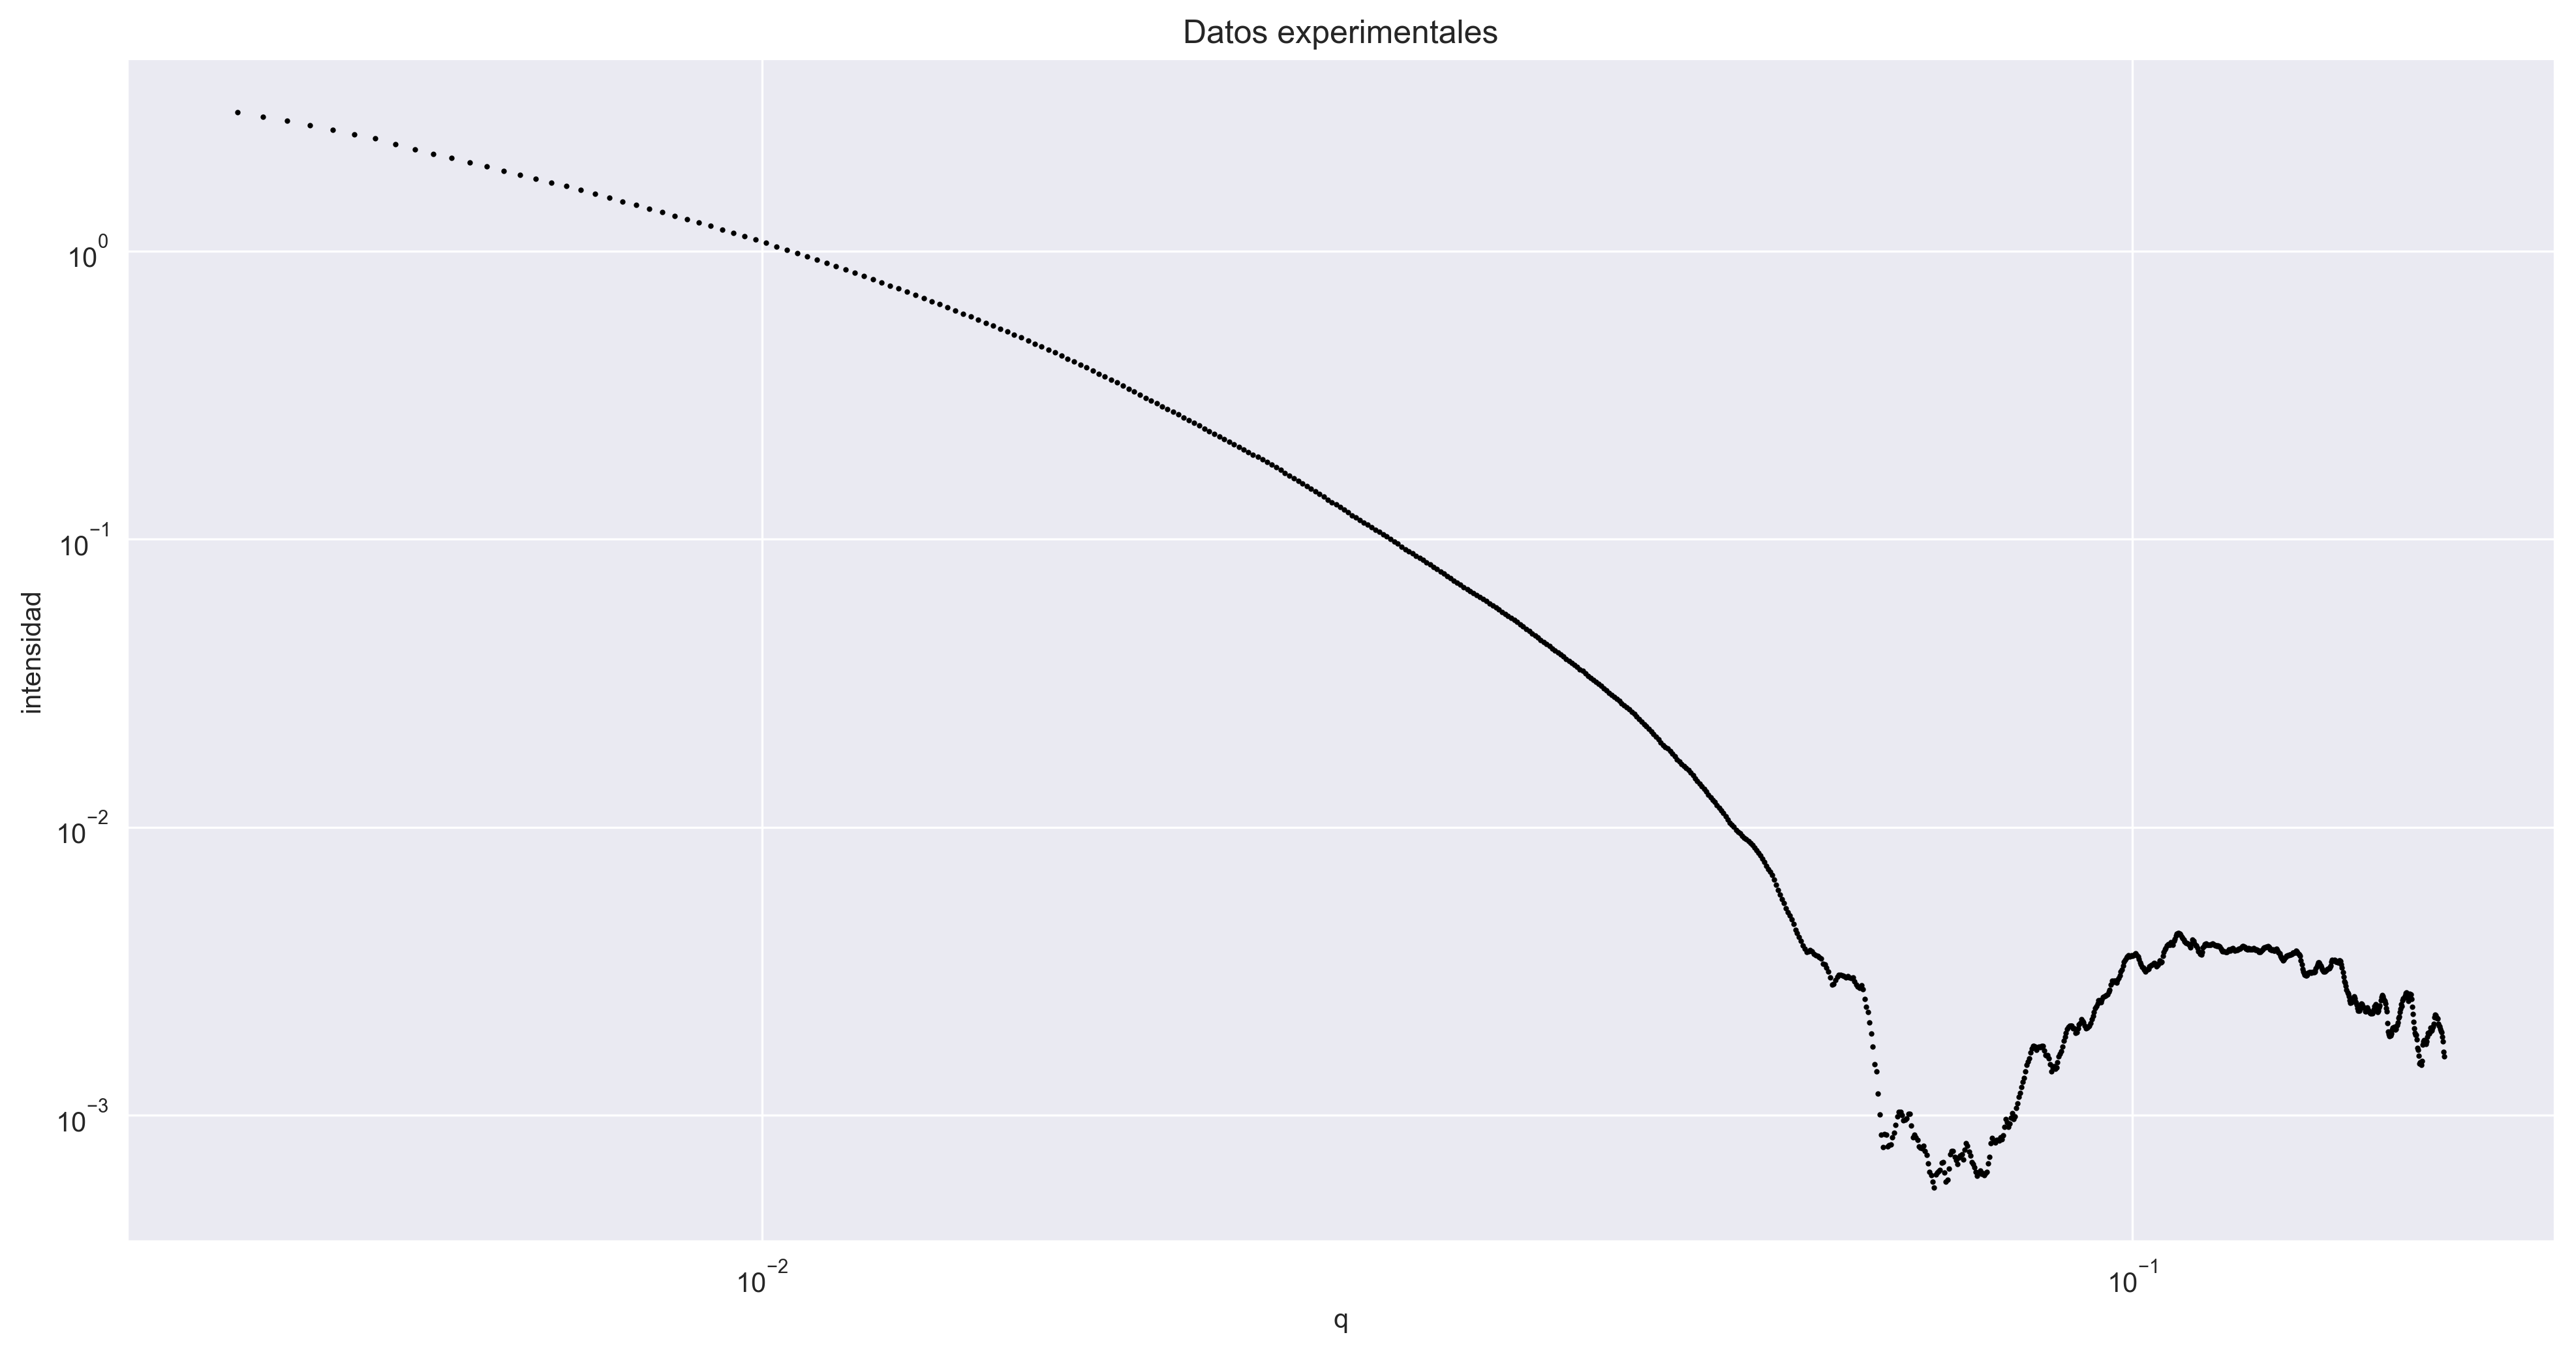

In [5]:
plt.figure(figsize = (16, 8), dpi = 300)
plt.plot(x_exp, y_exp, 'o', alpha=1, markersize=1, color="k")
plt.xscale("log")
plt.yscale("log")
plt.xlabel('q')
plt.ylabel('intensidad')
plt.title("Datos experimentales")
plt.show()

# Definimos todo lo necesario para poder usar los modelos

#### Definimos sigma

In [6]:
sigma = y_exp * .1 

#### Definimos las funciones base

In [7]:
funciones_base = [funcion_base_0, funcion_base_1]

#### Definimos los parámetros "originales"

In [8]:
# Tomamos como parámetros "originales" los encontrados por Cristián
c = .00000000001
p_lineales_original = np.array([.0001,c])
p_no_lineales_original = np.array([1.2 *10, 28 * 10, 2.96 * 10, 2.96 * 10, -4.7])

#### Definimos los rangos en los que se acota la búsqueda de cada parámetro

In [9]:
rangos_p_lineales = np.array([[0, .4]] * len(p_lineales_original)) #np.array([[-1.e-7, 1.e-7]] * len(p_lineales_original))
rangos_p_no_lineales = np.array([[5, 75], [5, 1500], [0,100], [0,100], [-10,10]])
#l = 5
#rangos_p_no_lineales = np.array([[p - np.abs(p) * l, p + np.abs(p) * l] for p in p_no_lineales_original])

In [10]:
rangos_p_lineales

array([[0. , 0.4],
       [0. , 0.4]])

In [11]:
rangos_p_no_lineales

array([[   5,   75],
       [   5, 1500],
       [   0,  100],
       [   0,  100],
       [ -10,   10]])

#### Esta variable sirve para setear la tolerancia en la ejecución de los modelos

In [12]:
valor_funcion_costo_original = 1

#### Usamos los parámetros encontrados por Cristián como modelo baseline

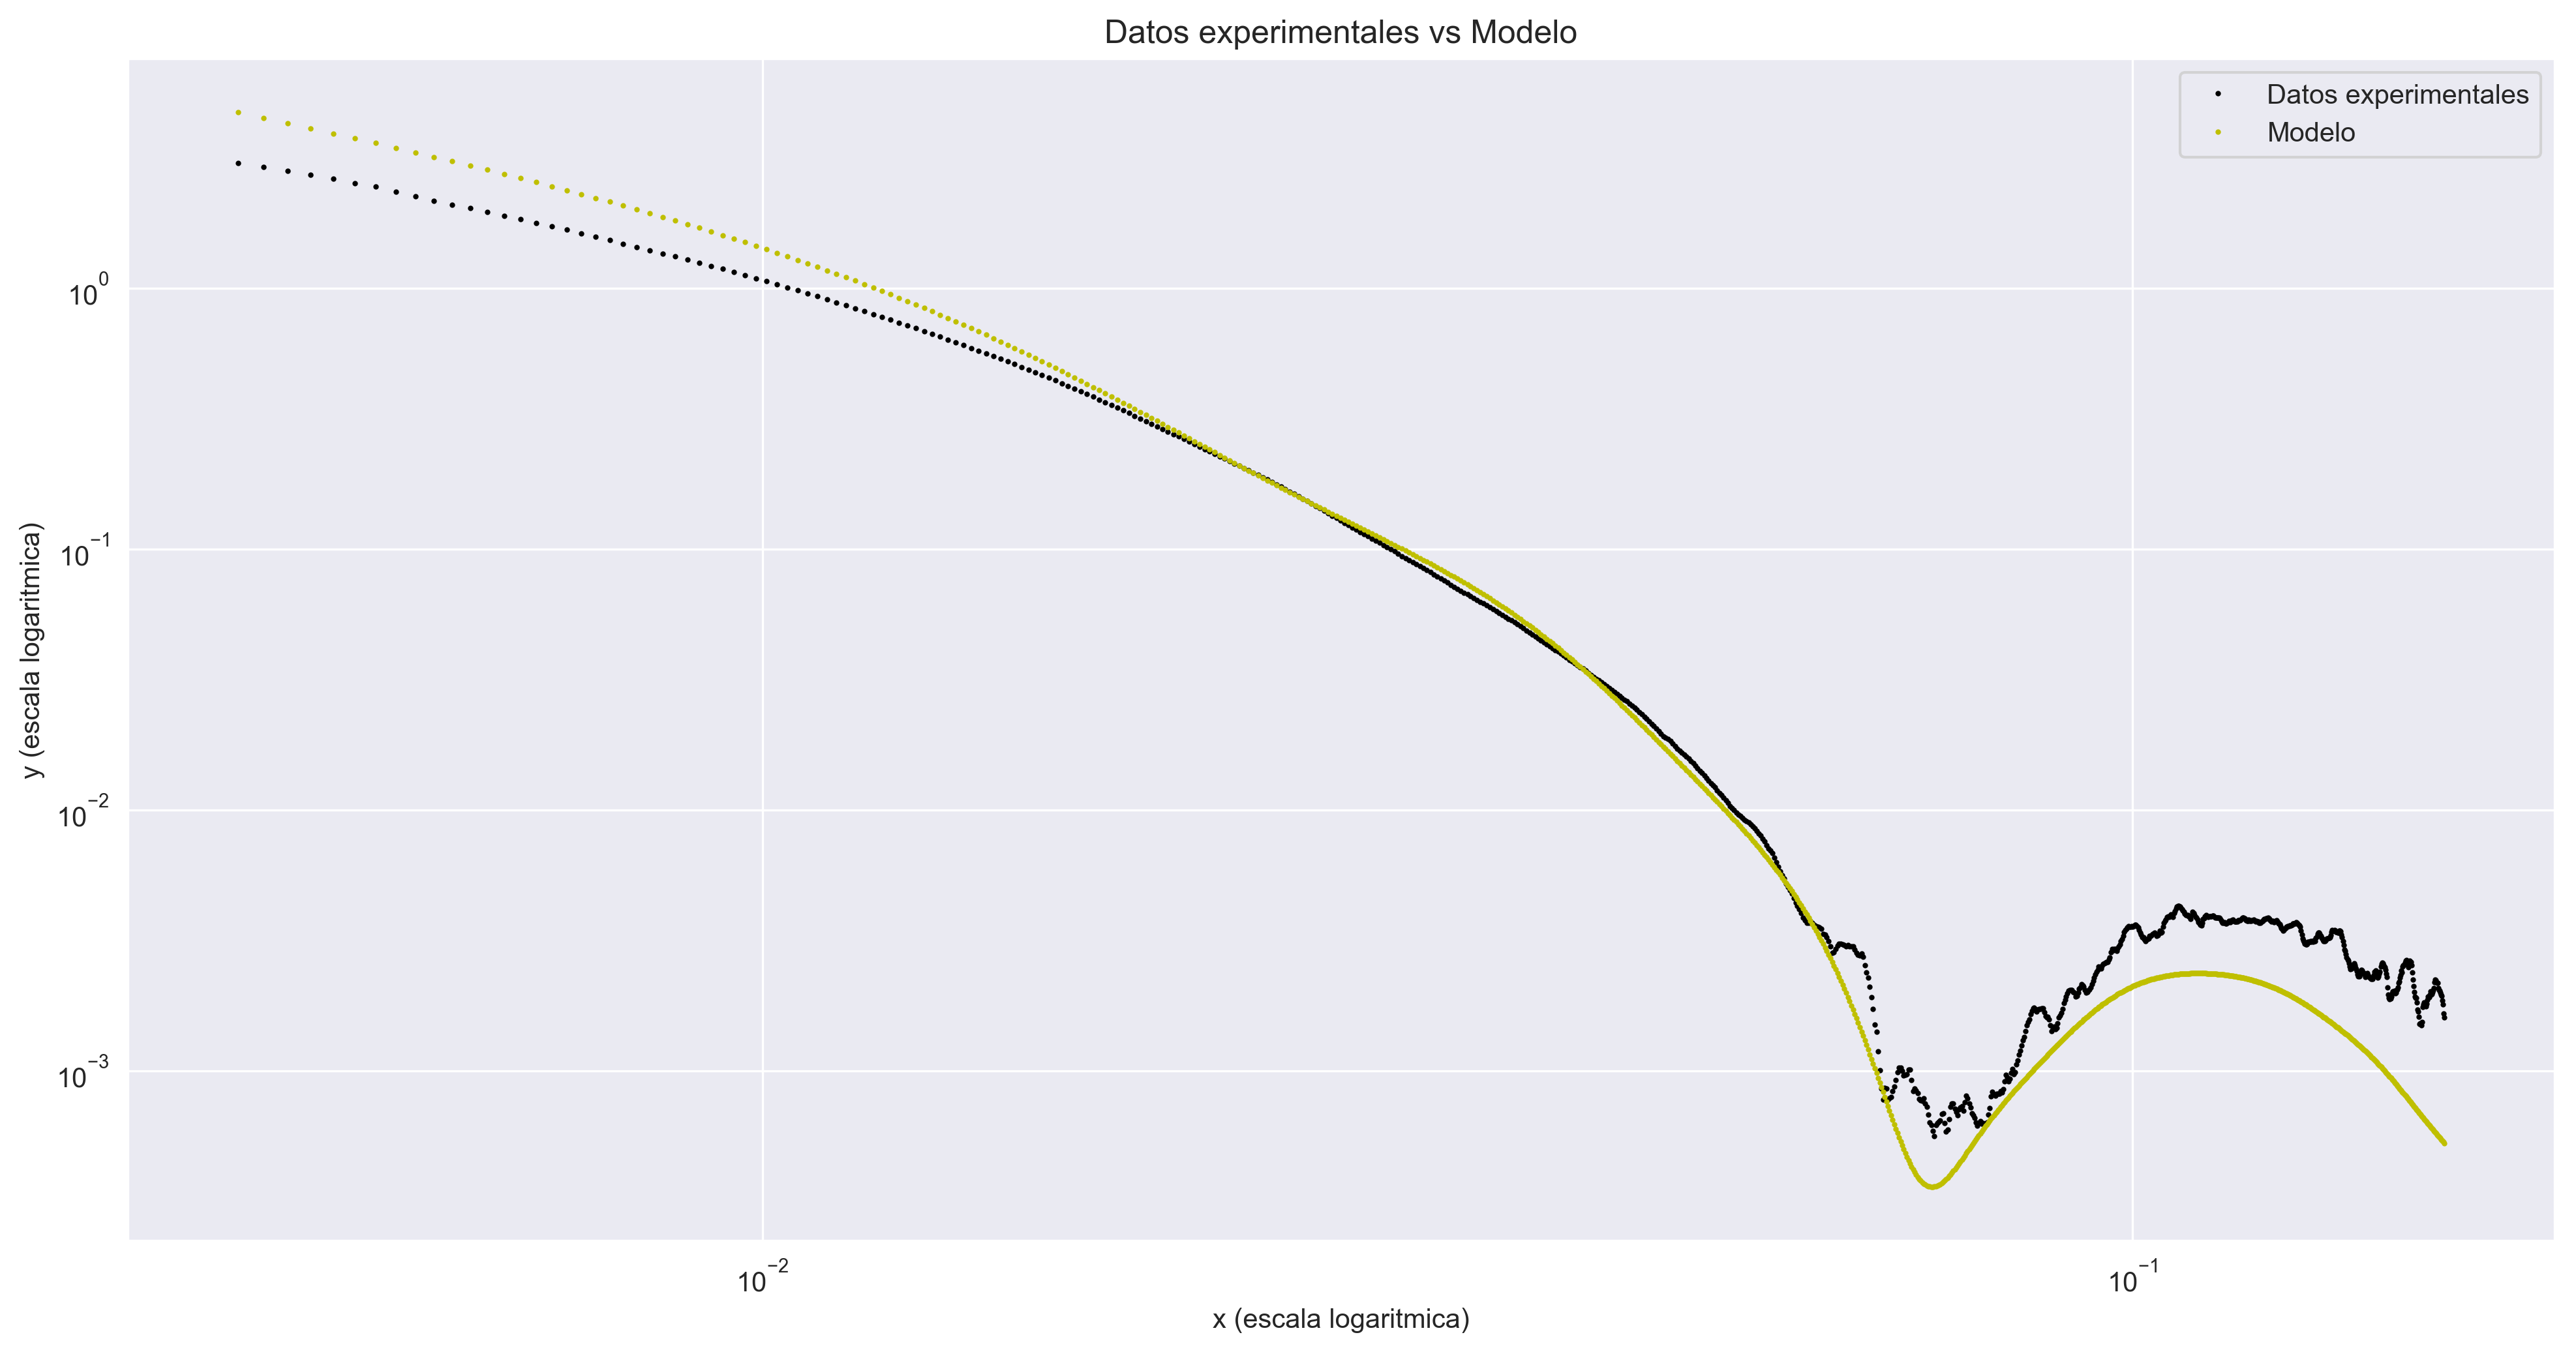

In [13]:
y_modelo_original = calcular_funcion_modelo(x_exp, funciones_base, p_lineales_original, p_no_lineales_original)

plt.figure(figsize = (16, 8), dpi = 300)
plt.plot(x_exp, y_exp, 'o', alpha=1, markersize=1, color="k", label = "Datos experimentales")
plt.plot(x_exp, y_modelo_original, 'o', alpha=1, markersize=1, color="y", label = "Modelo")
plt.xscale("log")
plt.yscale("log")
plt.xlabel('x (escala logaritmica)')
plt.ylabel('y (escala logaritmica)')
plt.title("Datos experimentales vs Modelo")
plt.legend()
plt.show()

#### Calculamos el $\chi^2$ correspondiente al modelo

In [14]:
chi2_original = valor_funcion_costo(y_exp, y_modelo_original, sigma, cant_p_lineales = len(p_lineales_original))
chi2_original

14.147899788462144

# Celdas para correr los métodos

#### Inicializamos el diccionario donde iremos guardando los resultados

In [15]:
correr_modelos = True
guardar_resultados = True

if correr_modelos:
    info_metodos = {}

## Método 1: Random Search

### - Se buscan los parámetros lineales y no lineales usando una uniforme:

Buscamos los parámetros con una uniforme dentro de los rangos especificados.

Finalmente nos quedamos con los parámetros con mejor $\chi^2$.

In [16]:
if correr_modelos:
    
    metodo = "metodo_1"
    iteraciones = 1000
    reinicios = 200

    t_inicial = process_time()

    valor_funcion_costo_optimo, p_l_optimo, p_no_l_optimo, info_debug, info_debug_inicializaciones = fit_metodo_1(
        x_exp, y_exp, sigma, valor_funcion_costo_original,
        p_lineales_original, p_no_lineales_original,
        rangos_p_lineales, rangos_p_no_lineales, 
        debug = True, 
        n_init = reinicios, max_iter = iteraciones, 
        tolerancia = 0
        )

    elapsed_time = process_time() - t_inicial

    info_metodos[metodo] = {"max_iter": iteraciones, "n_init":reinicios, 
                                "tiempo_ejecucion":elapsed_time,
                                "chi2_optimo": valor_funcion_costo_optimo,
                                "p_l_optimo": p_l_optimo.tolist(),
                                "p_no_l_optimo": p_no_l_optimo.tolist(),
                                "info_debug": info_debug,
                                "info_debug_inicializaciones": info_debug_inicializaciones}

    if guardar_resultados:
        dicc_save = info_metodos[metodo]
        dicc_save["metodo"] = metodo
        nombre_salida = str(dicc_save["metodo"]) + "-" + str(iteraciones) + "_" + str(reinicios) + '.txt'
        ruta_salida = 'C:/Users/f.costa/Desktop/Modelos/aplicacion_metodos_v5/' + nombre_salida
        imprimirJson(dicc_save, ruta_salida)

In [17]:
print(elapsed_time)

960.609375


In [18]:
playsound('Windows Logon Sound.wav')

### Método 1_1

Tomamos el método_1 y buscamos sólo los parámetros no lineales (con una uniforme dentro de los rangos especificados). Los lineales los hallamos haciendo un fit lineal (pueden caer fuera de los rangos especificados).

Finalmente nos quedamos con los parámetros con mejor $\chi^2$.

In [ ]:
if correr_modelos:
    
    metodo = "metodo_1_1"
    iteraciones = 1000
    reinicios = 200

    t_inicial = process_time()

    valor_funcion_costo_optimo, p_l_optimo, p_no_l_optimo, info_debug, info_debug_inicializaciones = fit_metodo_1_1(
        x_exp, y_exp, sigma, valor_funcion_costo_original,
        p_lineales_original, p_no_lineales_original,
        rangos_p_lineales, rangos_p_no_lineales, 
        debug = True, 
        n_init = reinicios, max_iter = iteraciones, 
        tolerancia = 0 
        )

    elapsed_time = process_time() - t_inicial

    info_metodos[metodo] = {"max_iter": iteraciones, "n_init":reinicios, 
                                "tiempo_ejecucion":elapsed_time,
                                "chi2_optimo": valor_funcion_costo_optimo,
                                "p_l_optimo": p_l_optimo.tolist(),
                                "p_no_l_optimo": p_no_l_optimo.tolist(),
                                "info_debug": info_debug,
                                "info_debug_inicializaciones": info_debug_inicializaciones}

    if guardar_resultados:
        dicc_save = info_metodos[metodo]
        dicc_save["metodo"] = metodo
        nombre_salida = str(dicc_save["metodo"]) + "-" + str(iteraciones) + "_" + str(reinicios) + '.txt'
        ruta_salida = 'C:/Users/f.costa/Desktop/Modelos/aplicacion_metodos_v5/' + nombre_salida
        imprimirJson(dicc_save, ruta_salida)

In [ ]:
print(elapsed_time)

## Método 2: Levenberg - Marquardt

Usamos la librería lmfit.

Por cada semilla llamamos al método, no controlamos las iteraciones ni tenemos registro de lo que va pasando iteración a iteración. Por lo tanto, sólo vamos a poder comparar el $\chi^2$ inicial y final contra los otros métodos.

In [22]:
if correr_modelos:
    
    metodo = "metodo_2"
    iteraciones = 0
    reinicios = 35

    t_inicial = process_time()

    valor_funcion_costo_optimo, p_l_optimo, p_no_l_optimo, info_debug, info_debug_inicializaciones = fit_metodo_2(
        x_exp, y_exp, sigma, valor_funcion_costo_original,
        p_lineales_original, p_no_lineales_original,
        rangos_p_lineales, rangos_p_no_lineales, 
        debug = True, 
        n_init = reinicios
        )

    elapsed_time = process_time() - t_inicial

    info_metodos[metodo] = {"max_iter": iteraciones, "n_init":reinicios, 
                                "tiempo_ejecucion":elapsed_time,
                                "chi2_optimo": valor_funcion_costo_optimo,
                                "p_l_optimo": p_l_optimo.tolist(),
                                "p_no_l_optimo": p_no_l_optimo.tolist(),
                                "info_debug": info_debug,
                                "info_debug_inicializaciones": info_debug_inicializaciones}

    if guardar_resultados:
        dicc_save = info_metodos[metodo]
        dicc_save["metodo"] = metodo
        nombre_salida = str(dicc_save["metodo"]) + "-" + str(iteraciones) + "_" + str(reinicios) + '.txt'
        ruta_salida = 'C:/Users/f.costa/Desktop/Modelos/aplicacion_metodos_v5/' + nombre_salida
        imprimirJson(dicc_save, ruta_salida)

In [23]:
print(elapsed_time)

571.609375


In [24]:
playsound('Windows Logon Sound.wav')

## Método 3: 
### - Búsqueda sólo de los parámetros no lineales
### - SA con:
### + Autorregulación de la temperatura (log_10)
### + Búsqueda con distribución normal, con varianza fija (proporcional a la longitud del rango de cada parámetro no lineal)

<p>Lo que haremos en este proceso es ubicarnos en el espacio de los parámetros no lineales y elegir un punto al azar con una distribución uniforme, pudiendo acotar el rango de esa uniforme. Para acotar ese rango, se debe modificar el parámetro <i>radios_rango_p_no_lineales</i> de la función <i>fit_metodo_3( )</i>.</p>

<p>Una vez hecho esto, tenemos que los parámetros no lineales tienen un valor fijo, y nos resta buscar los parámetros lineales. Pero para este caso, encontrar los parámetros lineales que mejor se ajusten a los datos experimentales es un problema de regresión lineal. Por lo tanto, podemos encontrar los parámetros lineales que optimicen la figura de mérito para los parámetros no lineales que tenemos fijos. Para encontrar estos parámetros lineales usamos las ecuaciones normales. Una vez encotrados los parámetros lineales, evaluamos el valor de la figura de mérito (o valor de la función de costo) para estos m parámetros en particular. </p>

<p>Ahora buscamos un nuevo set de parámetros no lineales, y esto lo hacemos con una normal centrada en los parámetros no lineales y desviación estándar proporcional al rango de cada parámetro no lineal. Una vez hecho esto, encontramos los parámetros lineales con las ecuaciones normales y evaluamos el valor de la figura de mérito para estos m parámetros en particular. Si el valor de la figura de mérito decae, aceptamos estos nuevos parámetros. Si no decae, podremos aceptarlos igualmente con cierta probabilidad. Esta probablidad es: $\min \lbrace{ \exp(\dfrac{\chi^2_{busqueda} - \chi^2_{new}}{t}), 1 \rbrace}$, donde t es lo que llamamos la temperatura del sistema. Esta probabilidad de aceptar un cambio, aunque haga crecer el valor de la figura de mérito, permite al algoritmo tener cierta chance de escapar de los mínimos locales. Mientras más chica sea la temperatura, menos probable será aceptar parámetros que produzcan un crecimiento en el valor de la figura de mérito. Esta temperatura se autorregulará en función del valor de la figura de mérito. Es así que el sistema comenzará el proceso con una temperatura alta, que irá decreciendo a medida que el valor de la figura de mérito decrezca. Decimos en ese caso que el sistema se va enfríando. </p>

<p>Volvemos a buscar un nuevo de set de parámetros no lineales...</p>

<p>Repetimos el proceso hasta que la cantidad de iteraciones sea igual a <i>max_iter</i> o hasta que el valor de la figura de mérito sea menor que <i>tolerancia</i>.</p>

<p>Si hemos seteado el parámetro <i>n_init</i> de la función <i>fit_metodo_3( )</i> con un valor <i>n</i> mayor a 1, entonces se repetirá el proceso completo n veces, empezando en cada proceso desde un punto al azar.</p>

In [ ]:
if correr_modelos:
    
    metodo = "metodo_3"
    iteraciones = 1000
    reinicios = 200

    t_inicial = process_time()

    valor_funcion_costo_optimo, p_l_optimo, p_no_l_optimo, info_debug, info_debug_inicializaciones = fit_metodo_3(
        x_exp, y_exp, sigma, valor_funcion_costo_original,
        p_lineales_original, p_no_lineales_original, 
        rangos_p_lineales, rangos_p_no_lineales, 
        debug = True, 
        n_init = reinicios, max_iter = iteraciones, 
        tolerancia = 0,
        burn_in_max_iter = 0, burn_in_temp = 0
        )

    elapsed_time = process_time() - t_inicial

    info_metodos[metodo] = {"max_iter": iteraciones, "n_init":reinicios, 
                                "tiempo_ejecucion":elapsed_time,
                                "chi2_optimo": valor_funcion_costo_optimo,
                                "p_l_optimo": p_l_optimo.tolist(),
                                "p_no_l_optimo": p_no_l_optimo.tolist(),
                                "info_debug": info_debug,
                                "info_debug_inicializaciones": info_debug_inicializaciones}

    if guardar_resultados:
        dicc_save = info_metodos[metodo]
        dicc_save["metodo"] = metodo
        nombre_salida = str(dicc_save["metodo"]) + "-" + str(iteraciones) + "_" + str(reinicios) + '.txt'
        ruta_salida = 'C:/Users/f.costa/Desktop/Modelos/aplicacion_metodos_v5/' + nombre_salida
        imprimirJson(dicc_save, ruta_salida)

In [ ]:
print(elapsed_time)

In [ ]:
playsound('Windows Logon Sound.wav')

### Método 3_1: 

es el exactamente el método 3, pero para no sobreescibir los datos los llamé así. lo que cambia es que en este consideré una etapa de burn in

In [ ]:
if correr_modelos:
    
    metodo = "metodo_3_1"
    iteraciones = 1001
    reinicios = 200

    t_inicial = process_time()

    valor_funcion_costo_optimo, p_l_optimo, p_no_l_optimo, info_debug, info_debug_inicializaciones = fit_metodo_3_1(
        x_exp, y_exp, sigma, valor_funcion_costo_original,
        p_lineales_original, p_no_lineales_original, 
        rangos_p_lineales, rangos_p_no_lineales, 
        debug = True, 
        n_init = reinicios, max_iter = iteraciones, 
        tolerancia = 0,
        burn_in_max_iter = iteraciones * .2, burn_in_temp = 30
        )

    elapsed_time = process_time() - t_inicial

    info_metodos[metodo] = {"max_iter": iteraciones, "n_init":reinicios, 
                                "tiempo_ejecucion":elapsed_time,
                                "chi2_optimo": valor_funcion_costo_optimo,
                                "p_l_optimo": p_l_optimo.tolist(),
                                "p_no_l_optimo": p_no_l_optimo.tolist(),
                                "info_debug": info_debug,
                                "info_debug_inicializaciones": info_debug_inicializaciones}

    if guardar_resultados:
        dicc_save = info_metodos[metodo]
        dicc_save["metodo"] = metodo
        nombre_salida = str(dicc_save["metodo"]) + "-" + str(iteraciones) + "_" + str(reinicios) + '.txt'
        ruta_salida = 'C:/Users/f.costa/Desktop/Modelos/aplicacion_metodos_v5/' + nombre_salida
        imprimirJson(dicc_save, ruta_salida)

In [ ]:
print(elapsed_time)

In [ ]:
playsound('Windows Logon Sound.wav')